# Vectorization and Topic Modeling

In this notebook, I build a custom tf-idf vectorizer to handle our preprocessed and tokenized data. I then use Latent Semantic Analysis (LSA) to generate topics that will be used as features in classification models.

## Import modules and data

In [59]:
import pandas as pd
import numpy as np
import spacy
import textacy
import pickle
import time
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD

In [33]:
with open('../data/tokenized_rest_reviews.pkl', 'rb') as f:
    rests = pickle.load(f)

In [2]:
with open('../data/tokenized_bs_reviews.pkl', 'rb') as bus:
    bus = pickle.load(bus)

## Build the custom tf-idf vectorizer

Scikit-learn's tf-idf vectorizer by default is implemented as a three component function, containing an analyzer, tokenizer and a preprocessor. Due to this three component structure, I will need to construct a custom vectorizer using the tf-idf framework that takes into account that our data is already processed and tokenized. We use the `identity` function to tell the vectorizer to not modify the text in the tokenizer and preprocessor stages.

In [3]:
def identity(doc):
    return doc

In [4]:
vectorizer = TfidfVectorizer(analyzer='word', tokenizer=identity, preprocessor=identity, 
                             token_pattern=None, strip_accents='ascii', min_df=5, max_df=0.95,
                             max_features=10000, use_idf=True, sublinear_tf=True)

## Create document-term sparse matrices

### Restaurants

In [34]:
doc_term_matrix = vectorizer.fit_transform((doc for doc in rests))

### Businesses

In [5]:
doc_term_matrix = vectorizer.fit_transform((doc for doc in bus))

## Create topic models and print out topics

I compared the topic generation of two decomposition models: Latent Semantic Analysis (LSA) and non-Negative Matrix Factorization (NMF) on the restaurant review dataset. 

Research (**Blei et. al (2003)** http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf, **Stevens et. al (2012)** http://aclweb.org/anthology/D/D12/D12-1087.pdf) suggests that the most important characteristic of topics used in text classification to improve accuracy is the *quality* of topics; thus we should choose the topic modeling that gives the most topics relevant to the review space.

While both NMF and LSA could be fit on an AWS t2.2xlarge instance, topics generated by NMF are heavily weighted toward the primary term for each topic whereas the topics generated by LSA cover a greater breadth of terms with term weights varying throughout the set of topics. LSA was chosen due to its much faster fit time, increased term coverage per topic, and potential for expansion. 

The two below functions will be used to visually inspect topics and the top documents in each corpus for the topics created by our models.

In [17]:
def print_topics(model, n_topics, n_terms):
    for topic_idx, top_terms in model.top_topic_terms(vectorizer.get_feature_names(), topics=n_topics, top_n=n_terms):
        print('topic', topic_idx, ':', '   '.join(top_terms))

In [7]:
def top_topic_docs(corpus, model, doc_topic_matrix, n_topics):
    for topic_idx, top_docs in model.top_topic_docs(doc_topic_matrix, topics=n_topics, top_n=1):
        print(topic_idx)
        for j in top_docs:
            print(corpus[j])

## LSA - Businesses

In [8]:
%%time
lsa_model_bs = TruncatedSVD(n_components=325, random_state=1)
lsa_model_bs.fit(doc_term_matrix)

CPU times: user 12min 14s, sys: 2min 32s, total: 14min 47s
Wall time: 7min 44s


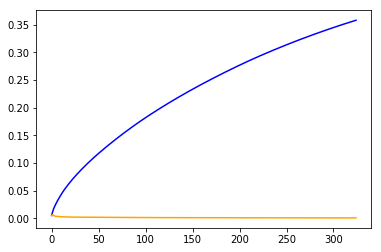

In [18]:
plt.plot(range(325), np.cumsum(lsa_model_bs.explained_variance_ratio_), color='blue', label='Cumulative % variance')
plt.plot(range(325), lsa_model_bs.explained_variance_ratio_, color='orange', label='% variance explained')

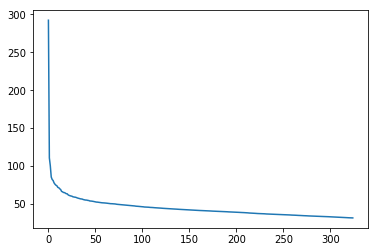

In [11]:
plt.plot(range(325), lsa_model_bs.singular_values_)

We can see that the amount of cumulative explained variance continuously increases as we add topics; however, due to memory limitations I have chosen to restrict the model to 350 components which explain 35% of total variance. While this loss is regrettable, we will only be using the topics to supplement other features in our classification models and thus regain some of the lost information.

In [20]:
lsa_model_bs = textacy.TopicModel('lsa', n_topics=325, random_state=1)
lsa_model_bs.fit(doc_term_matrix)
lsa_dt_matrix_bs = lsa_model_bs.transform(doc_term_matrix)

/opt/conda/lib/python3.6/site-packages/matplotlib/collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


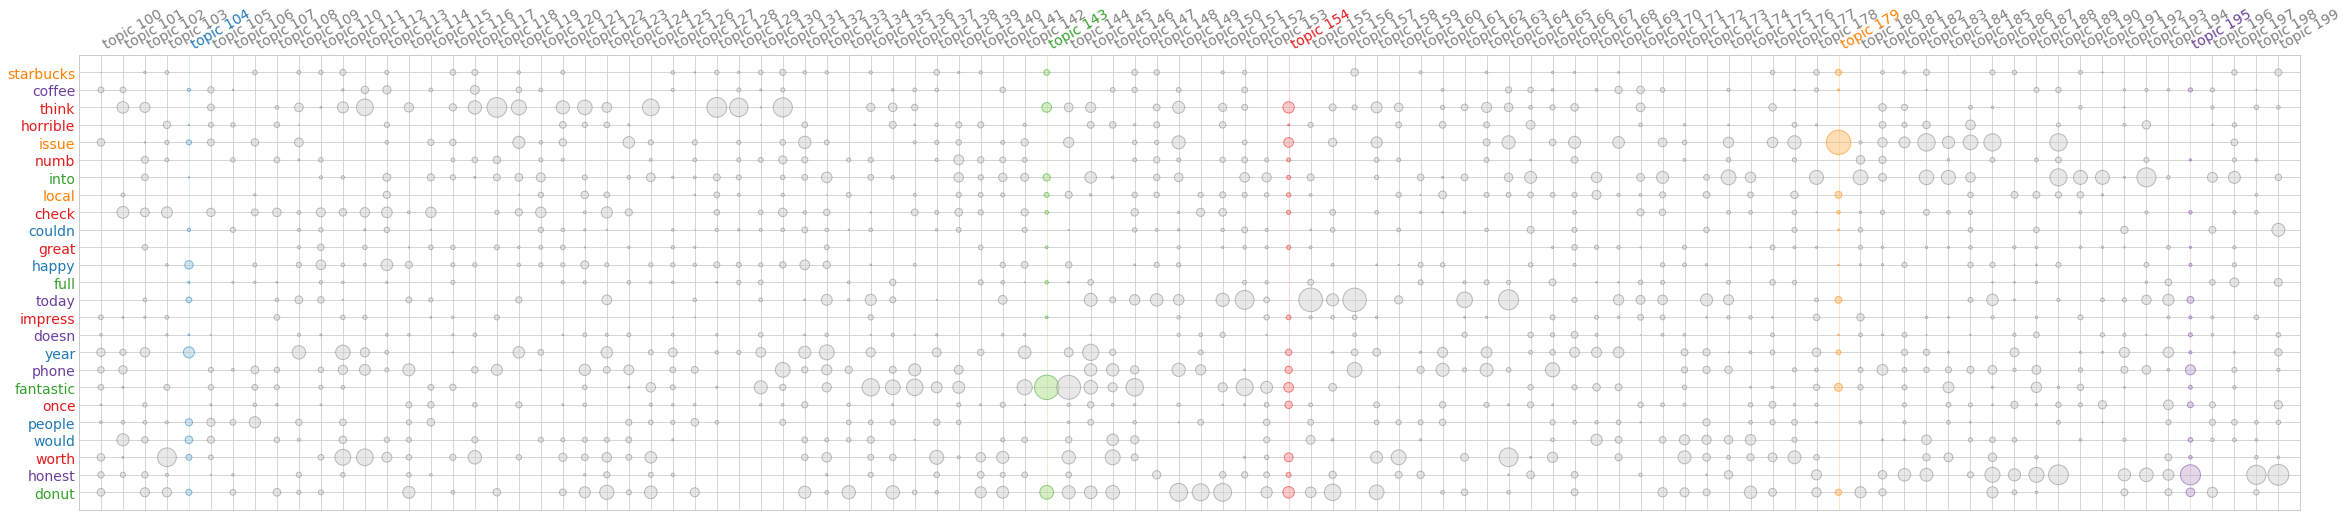

In [28]:
lsa_model_bs.termite_plot(doc_term_matrix, 
                          vectorizer.get_feature_names(), 
                          n_terms=25,
                          highlight_topics=[104, 143, 154, 179, 195],
                          topics=[num for num in range(100, 200)])

In [22]:
print_topics(lsa_model_bs)

topic 0 : they   numb   this   that   have   be   with   great   very   place
topic 1 : great   very   friendly   staff   recommend   highly   always   service   place   amaze
topic 2 : service   call   recommend   them   customer   company   highly   professional   would   thank
topic 3 : service   customer   store   they   price   always   great   their   selection   location
topic 4 : service   great   hotel   numb   vega   customer   night   stay   room   strip
topic 5 : staff   very   friendly   helpful   clean   hotel   store   room   location   office
topic 6 : numb   here   nail   staff   friendly   always   clean   back   salon   place
topic 7 : recommend   place   they   highly   numb   this   them   would   company   have
topic 8 : always   great   have   year   be   with   show   every   vega   here
topic 9 : great   price   numb   they   nail   selection   reasonable   them   very   do
topic 10 : great   staff   place   call   office   friendly   doctor   this   make   dri

topic 177 : another   such   beyond   shop   issue   above   wrong   absolutely   color   worth
topic 178 : such   park   extremely   different   into   color   month   another   wait   then
topic 179 : issue   same   cheap   stuff   small   minute   another   extremely   cupcake   night
topic 180 : beyond   above   into   another   atmosphere   disappoint   where   last   product   something
topic 181 : treat   cheap   absolutely   shop   house   bring   color   sweet   another   cupcake
topic 182 : atmosphere   color   shop   keep   comfortable   another   month   front   knowledgeable   than
topic 183 : issue   airport   into   buy   fresh   flavor   shop   want   honest   such
topic 184 : where   reasonable   anyone   into   color   extremely   issue   night   start   perfect
topic 185 : absolutely   where   buy   issue   stuff   park   favorite   treat   dentist   offer
topic 186 : front   issue   comfortable   honest   park   through   want   than   different   patient
topic 187 

In [29]:
np.save('../data/business_doc_topic_matrix.npy', lsa_dt_matrix_bs)

## LSA - Restaurants

Only 200 topics from the restaurant reviews can be included due to memory limitations.

### Plot explained variance

In [35]:
%%time
lsa_model = TruncatedSVD(n_components=200, random_state=1)
lsa_model.fit(doc_term_matrix)

CPU times: user 11min 39s, sys: 2min 45s, total: 14min 24s
Wall time: 8min 5s


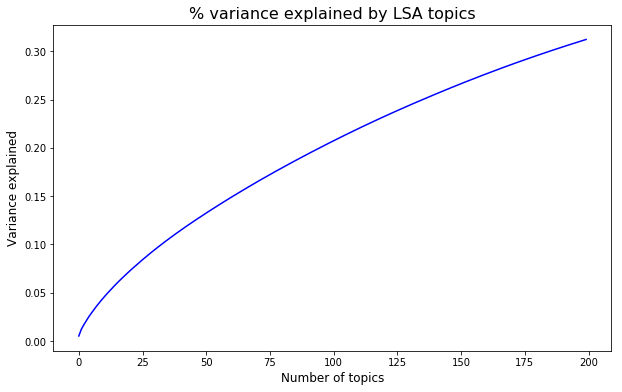

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(range(200), np.cumsum(lsa_model.explained_variance_ratio_), color='blue', label='Cumulative % variance')
plt.title('% variance explained by LSA topics', size=16)
plt.xlabel('Number of topics', size=12)
plt.ylabel('Variance explained', size=12)

We can see that adding more topics should improve the percentage of variance explained by the topics.

## Show topics and create termite plots

In [ ]:
%%time
lsa_model = textacy.TopicModel('lsa', n_topics=200)
lsa_model.fit(doc_term_matrix)

lsa_doc_topic_matrix = lsa_model.transform(doc_term_matrix)

/opt/conda/lib/python3.6/site-packages/matplotlib/collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


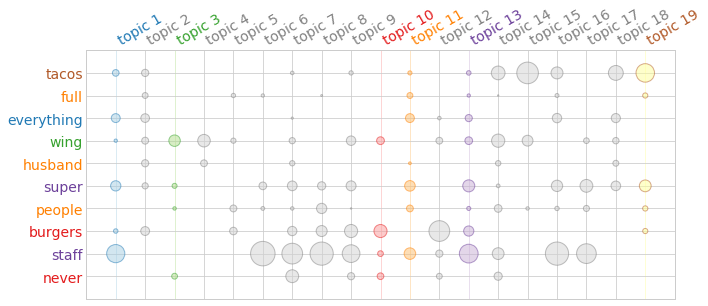

In [28]:
plt.figure(figsize=(50, 35))
lsa_model.termite_plot(doc_term_matrix,
                       vectorizer.get_feature_names(), 
                       topics=[num for num in range(1, 20)],
                       n_terms=10, 
                       highlight_topics=[1, 3, 10, 11, 13, 19])

In [18]:
print_topics(lsa_model, n_topics=[num for num in range(1, 20)], n_terms=5)

topic 1 : great   service   friendly   place   amaze
topic 2 : chicken   fry   with   sauce   delicious
topic 3 : pizza   place   this   always   they
topic 4 : pizza   great   service   order   numb
topic 5 : great   numb   price   service   lunch
topic 6 : very   friendly   staff   sushi   price
topic 7 : always   they   staff   friendly   have
topic 8 : staff   friendly   very   place   burger
topic 9 : numb   chicken   fry   place   burger
topic 10 : back   will   price   burger   definitely
topic 11 : numb   breakfast   here   definitely   amaze
topic 12 : burger   fry   burgers   amaze   here
topic 13 : sushi   great   roll   staff   fresh
topic 14 : here   chicken   be   drink   night
topic 15 : they   their   have   tacos   amaze
topic 16 : amaze   staff   much   friendly   chicken
topic 17 : recommend   really   would   highly   friendly
topic 18 : amaze   really   service   very   breakfast
topic 19 : always   really   delicious   service   their


From the above 20 topics, we can see that LSA does not necessarily aggregate topics under one primary term, but does a good job at creating similar topics that encapsulate the variation of documents speaking to similar subjects:

| Topic 	| Terms 	|
|:----------------------:	|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| **Good service/staff** 	| **Topic 1** : great   service   friendly   place   amaze<br> **Topic 5** : great   numb   price   service   lunch<br> **Topic 6** : very   friendly   staff   sushi   price<br> **Topic 7** : always   they   staff   friendly   have<br> **Topic 8** : staff   friendly   very   place   burger<br> **Topic 16** : amaze   staff   much   friendly   chicken<br> **Topic 18** : amaze   really   service   very   breakfast<br> **Topic 19** : always   really   delicious   service   their 	|
| **Pizza** 	| **Topic 3** : pizza   place   this   always   they<br> **Topic 4** : pizza   great   service   order   numb 	|
| **Recommendation** 	| **Topic 17** : recommend   really   would   highly   friendly 	|
| **Sushi** 	| **Topic 13** : sushi   great   roll   staff   fresh 	|
| **Fried Chicken** 	| **Topic 2** : chicken   fry   with   sauce   delicious<br> **Topic 9** : numb   chicken   fry   place   burger 	|
| **Tacos** 	| **Topic 15** : they   their   have   tacos   amaze 	|
| **Burgers** 	| **Topic 10** : back   will   price   burger   definitely<br> **Topic 12** : burger   fry   burgers   amaze   here 	|
| **Breakfast** 	| **Topic 11** : numb   breakfast   here   definitely   amaze 	|
| **Bars/Wings** 	| **Topic 14** : here   chicken   be   drink   night 	|

In [19]:
np.save('../data/rests_dt_matrix.npy', lsa_doc_topic_matrix)

### NMF

In [22]:
%%time
nmf_model = textacy.TopicModel('nmf', n_topics=50, n_jobs=-1)
nmf_model.fit(doc_term_matrix)

CPU times: user 1h 29min 46s, sys: 3min 6s, total: 1h 32min 53s
Wall time: 1h 28min 27s


In [23]:
doc_topic_matrix_nmf = nmf_model.transform(doc_term_matrix)

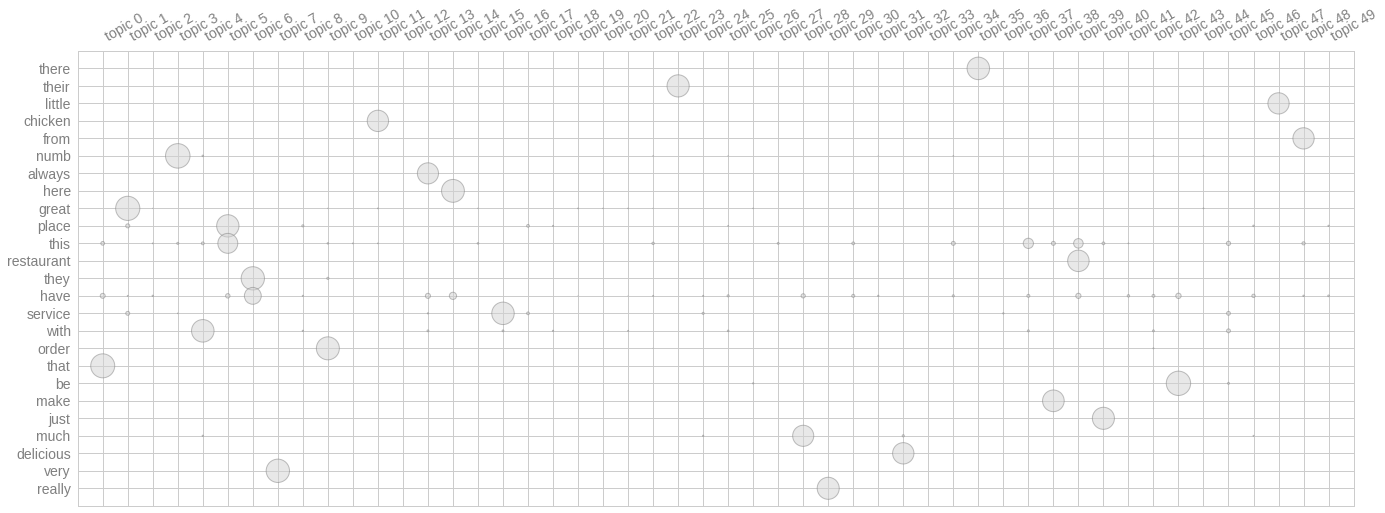

In [25]:
nmf_model.termite_plot(doc_term_matrix, vectorizer.get_feature_names(), topics=[num for num in range(0, 50, 1)])

In [ ]:
topics_and_top_docs(nmf_model, doc_topic_matrix_nmf, topics=[num for num in range(0, 25, 1)])

topic 0 : be   both   table   server   seat   time   disappoint   since   which   experience
topic 1 : great   atmosphere   price   selection   place   happy   fantastic   patio   music   service
topic 2 : pizza   crust   slice   cheese   wing   topping   pepperoni   delivery   sauce   italian
topic 3 : numb   minute   star   only   about   wait   give   after   people   hour
topic 4 : with   sauce   which   cheese   friend   side   some   also   flavor   sweet
topic 5 : place   this   look   about   from   favorite   review   location   find   vega
topic 6 : they   them   make   also   when   close   because   serve   offer   give
topic 7 : very   tasty   attentive   clean   good   also   portion   reasonable   small   price
topic 8 : sushi   roll   sashimi   salmon   quality   japanese   tempura   spicy   nigiri   happy
topic 9 : order   minute   take   when   wait   after   ask   wrong   call   then
topic 10 : burger   fry   burgers   cheese   onion   shake   bacon   patty   ring   

In [27]:
with open('../data/nmf_doctopic_matrix.pkl', 'wb') as f:
    pickle.dump(doc_topic_matrix_nmf, f)